In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import torch.nn.init as init

fnexpr='GSE117931/GSE117931_GPL14951.tsv'
fnmet='GSE117931/GSE117931_GPL13534.tsv'
fnassig='GSE117931/assig.csv'
nsamp=37
fnmodel='VAEREAL6499'
filename = "VAEREAL-"
ldim=1000
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 4096),
            nn.BatchNorm1d(4096),
            nn.LeakyReLU(0.2),
            nn.Linear(4096, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 2 * latent_dim)  # 2 for mean and variance
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 4096),
            nn.BatchNorm1d(4096),
            nn.LeakyReLU(0.2),
            nn.Linear(4096, input_dim),
            nn.Sigmoid()
        )
        self._initialize_weights()
    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                # He initialization for weights of Linear layers with Leaky ReLU
                init.kaiming_normal_(module.weight, nonlinearity='leaky_relu')
                if module.bias is not None:
                    init.constant_(module.bias, 0)
                    
    def reparameterize(self, mu, logvar):
        #logvar = torch.clamp(logvar, min=-1, max=1)
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        #recon = torch.sigmoid(recon) 
        return recon, mu, logvar

        
# Leer datos
expression_data = pd.read_csv(fnexpr,sep='\t', index_col=0)
expression_data=expression_data.T
methylation_data = pd.read_csv(fnmet,sep='\t', index_col=0)
methylation_data=methylation_data.T
assign_data = pd.read_csv(fnassig,sep='\t')

expression_data = expression_data.iloc[:, 1:]
methylation_data = methylation_data.iloc[:, 1:]
assign_data = assign_data.iloc[:, 1:]

# Convertir todas las columnas a tipo float
expression_data = expression_data.apply(pd.to_numeric, errors='coerce')
methylation_data = methylation_data.apply(pd.to_numeric, errors='coerce')
assign_data = assign_data.apply(pd.to_numeric, errors='coerce')
# Lidiar con valores NaN (si los hay). 

methylation_data.dropna(axis=1, inplace=True)
#expression_data.fillna(0, inplace=True)
#methylation_data.fillna(0, inplace=True)
#assign_data.fillna(0, inplace=True)



# Normalizacion
scaler = MinMaxScaler()


expression_data_scaled = scaler.fit_transform(expression_data)
methylation_data_scaled = scaler.fit_transform(methylation_data)
assign_data_scaled =assign_data

# Convertir de vuelta a DataFrames
expression_data = pd.DataFrame(expression_data_scaled, index=expression_data.index, columns=expression_data.columns)
methylation_data = pd.DataFrame(methylation_data_scaled, index=methylation_data.index, columns=methylation_data.columns)
assign_data = pd.DataFrame(assign_data_scaled, index=assign_data.index, columns=assign_data.columns)

print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device="cpu"




True


In [2]:
# Convertirlos a tensores y pasarlos a la GPU
expression_data = torch.FloatTensor(expression_data.values).to(device)
methylation_data = torch.FloatTensor(methylation_data.values).to(device)
assign_data = torch.FloatTensor(assign_data.values).to(device)

combined_data = torch.cat((expression_data,methylation_data,assign_data), 1).to(device)

## # Modelos y optimizadores
vae = VAE(combined_data.shape[1],ldim).to(device)
start_epoch=6300
vae.load_state_dict(torch.load(f"{fnmodel}{start_epoch-1}.pth"))
print(f'El modelo VAE tiene {count_parameters(vae)} parámetros entrenables.')
vae_optimizer = optim.RMSprop(vae.parameters(), lr=0.0002)

# Función de pérdida para VAE
def loss_vae(recon_x, x, mu, logvar):
    #recon_loss = nn.MSELoss(reduction='sum')(recon_x, x)  # pérdida de reconstrucción
    recon_loss = nn.BCELoss(reduction='sum')(recon_x, x)
    #recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # divergencia KL
    total_loss = 5*recon_loss + kl_divergence
    return total_loss, recon_loss, kl_divergence

# Entrenamiento
n_samples = combined_data.size(0)
batch_size = 8

n_epochs = 10000
start_time = time.time()
best_loss = float('inf')
for epoch in range(start_epoch,n_epochs):
    epoch_recon_loss = 0.0
    epoch_kl_divergence = 0.0

    for idx in range(0, n_samples, batch_size):
        real_data = combined_data[idx:idx+batch_size].to(device)

        vae_optimizer.zero_grad()
        
        recon_data, mu, logvar = vae(real_data)
        if ((epoch+1) % 100 == 0) and (idx ==0):
                print(real_data)
                print(torch.round(torch.tensor(recon_data), decimals=4))
        #print(torch.min(recon_data))
        #print(torch.max(recon_data))
        loss, recon_loss, kl_div = loss_vae(recon_data, real_data, mu, logvar)
        epoch_recon_loss += recon_loss.item()
        epoch_kl_divergence += kl_div.item()
        loss.backward()
              # Verificar si la pérdida es NaN
        if torch.isnan(loss):
            print("NaN detected!")
            break
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
        vae_optimizer.step()
        # Rastrear gradientes y valores extremos
        #for name, param in vae.named_parameters():
            #if param.grad is not None:
                #grad_max = torch.max(param.grad).item()
                #grad_min = torch.min(param.grad).item()
                #print(grad_max)
                #print(grad_min)
                #if torch.isnan(grad_max) or torch.isnan(grad_min):
                    #print(f'NaN encontrado en el gradiente de {name}')
                #elif grad_max > threshold or grad_min < -threshold:
                    #print(f'Gradiente extremo detectado en {name}: max {grad_max}, min {grad_min}')

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} | Total Loss: {loss.item()} | Recon Loss: {epoch_recon_loss/n_samples} | KL Div: {epoch_kl_divergence/n_samples}")
        end_time = time.time()
        
        # Calcular la diferencia de tiempo
        elapsed_time = end_time - start_time

        print(f"El código tardó {elapsed_time:.5f} segundos en ejecutarse.")
        start_time = time.time()

        if(loss.item()<best_loss):
            best_loss=loss.item()
            print("Saved model")
            torch.save(vae.state_dict(), f"{fnmodel}{epoch}.pth")




El modelo VAE tiene 3557644557 parámetros entrenables.
tensor([[0.1335, 0.5937, 0.3517,  ..., 0.9153, 0.8064, 0.0000],
        [0.1057, 0.3394, 0.6283,  ..., 0.4290, 0.6301, 0.0000],
        [0.0629, 0.0762, 0.7313,  ..., 0.4615, 0.6070, 0.0000],
        ...,
        [0.1786, 0.5062, 0.5522,  ..., 0.7494, 0.2252, 0.0000],
        [0.0000, 0.7278, 0.6297,  ..., 0.6616, 0.3653, 0.0000],
        [0.5029, 0.5469, 0.6237,  ..., 0.3380, 0.0000, 0.0000]])
tensor([[1.2420e-01, 6.0670e-01, 3.5330e-01,  ..., 9.2590e-01, 7.9110e-01,
         0.0000e+00],
        [1.0670e-01, 3.4130e-01, 6.2300e-01,  ..., 3.7200e-01, 6.7230e-01,
         0.0000e+00],
        [6.6200e-02, 7.7300e-02, 7.3160e-01,  ..., 4.5310e-01, 5.9590e-01,
         0.0000e+00],
        ...,
        [1.7250e-01, 5.2290e-01, 5.4770e-01,  ..., 7.5230e-01, 2.1060e-01,
         0.0000e+00],
        [8.0000e-04, 7.2670e-01, 6.2570e-01,  ..., 6.6150e-01, 3.8000e-01,
         0.0000e+00],
        [5.3000e-01, 4.8320e-01, 6.3030e-01,  ...

/tmp/ipykernel_5650/3077857749.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.round(torch.tensor(recon_data), decimals=4))


Epoch 6400/10000 | Total Loss: 5910776.5 | Recon Loss: 233295.7972972973 | KL Div: 273.6732639622044
El código tardó 16418.91635 segundos en ejecutarse.
Saved model
tensor([[0.1335, 0.5937, 0.3517,  ..., 0.9153, 0.8064, 0.0000],
        [0.1057, 0.3394, 0.6283,  ..., 0.4290, 0.6301, 0.0000],
        [0.0629, 0.0762, 0.7313,  ..., 0.4615, 0.6070, 0.0000],
        ...,
        [0.1786, 0.5062, 0.5522,  ..., 0.7494, 0.2252, 0.0000],
        [0.0000, 0.7278, 0.6297,  ..., 0.6616, 0.3653, 0.0000],
        [0.5029, 0.5469, 0.6237,  ..., 0.3380, 0.0000, 0.0000]])
tensor([[1.3910e-01, 5.9670e-01, 3.5560e-01,  ..., 9.0650e-01, 7.9540e-01,
         0.0000e+00],
        [1.1300e-01, 3.2420e-01, 6.1990e-01,  ..., 4.0390e-01, 6.4830e-01,
         0.0000e+00],
        [5.9600e-02, 7.2000e-02, 7.3500e-01,  ..., 4.8190e-01, 5.9620e-01,
         0.0000e+00],
        ...,
        [1.8160e-01, 5.2490e-01, 5.6410e-01,  ..., 7.4440e-01, 2.2850e-01,
         0.0000e+00],
        [7.0000e-04, 7.3060e-01, 6.3

KeyboardInterrupt: 

/home/fede/PyEnv/PB/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-31 10:11:52.547698: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-31 10:11:52.600638: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-31 10:11:52.600680: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-31 10:11:52.600714: E

Wasserstein Distance: 0.12720828001893605
KS Statistic: 0.2260557530317857, P-Value: 0.0
Distancia Euclidiana Promedio: 148.7584488313119
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        14

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



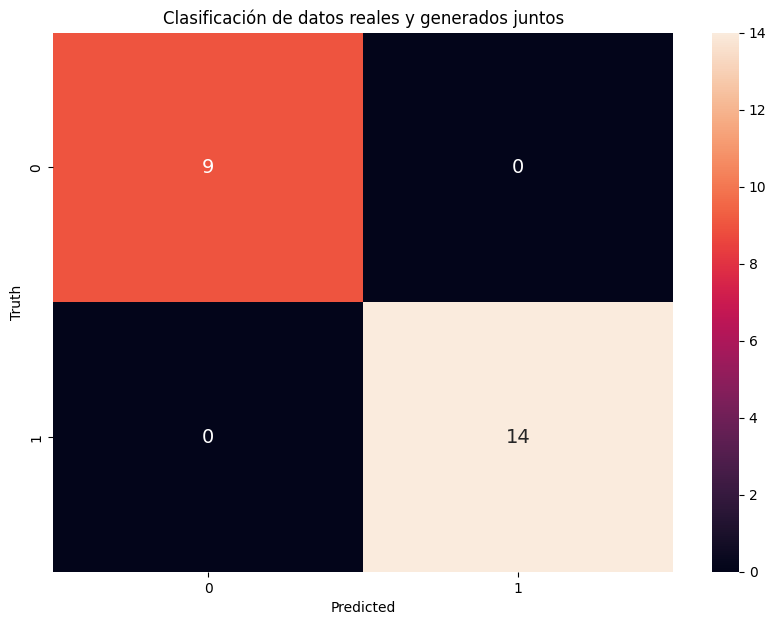

SVC: Solo una clase
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.80      0.89         5

    accuracy                           0.92        12
   macro avg       0.94      0.90      0.91        12
weighted avg       0.93      0.92      0.91        12



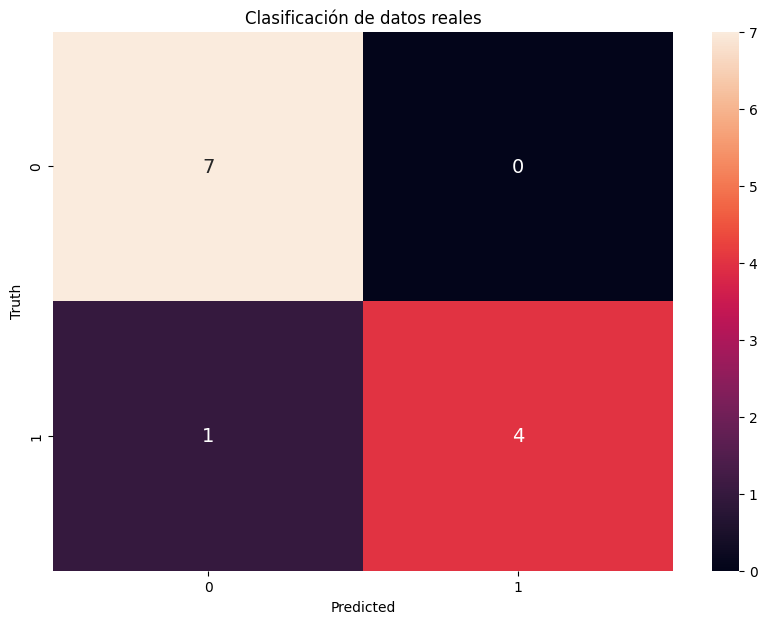

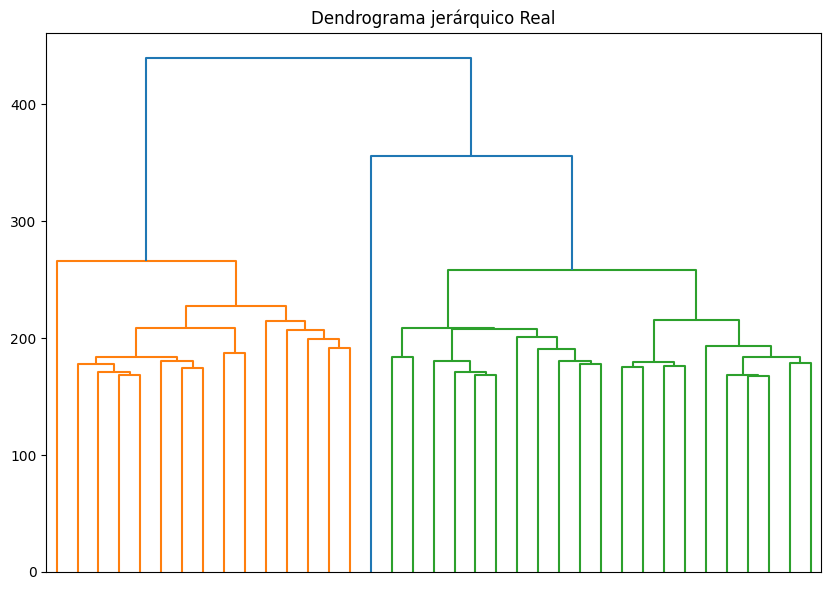

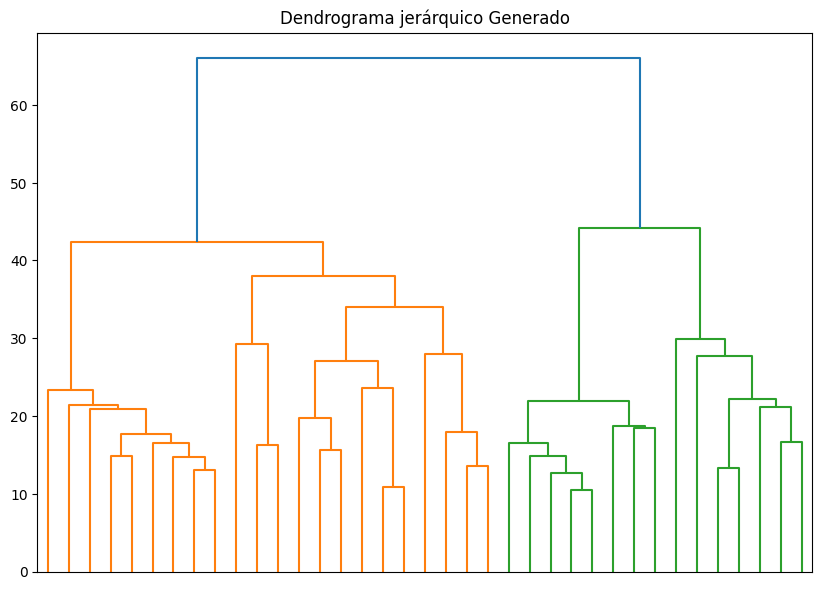

/home/fede/PyEnv/PB/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


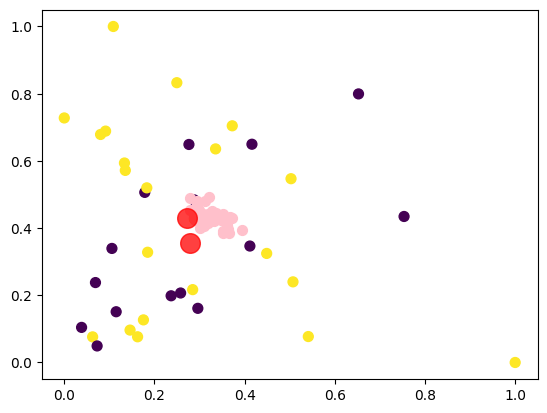

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

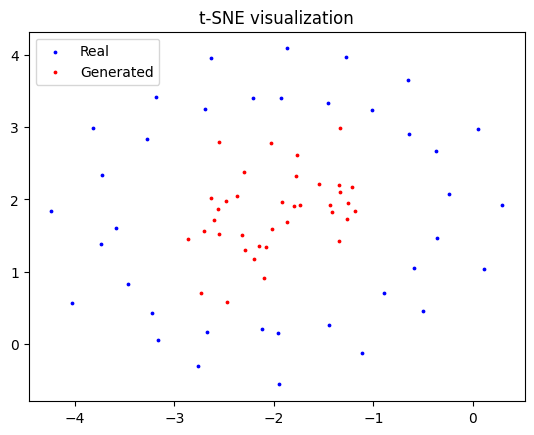

/home/fede/PyEnv/PB/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


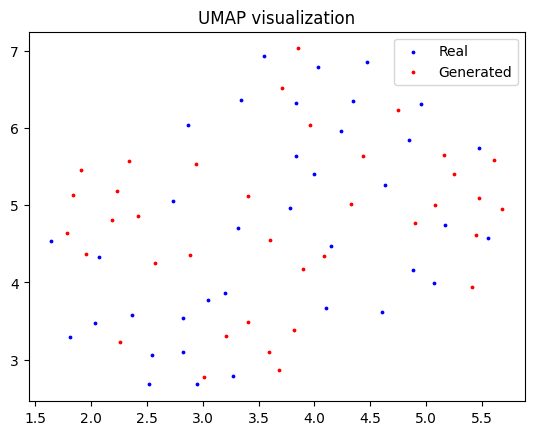

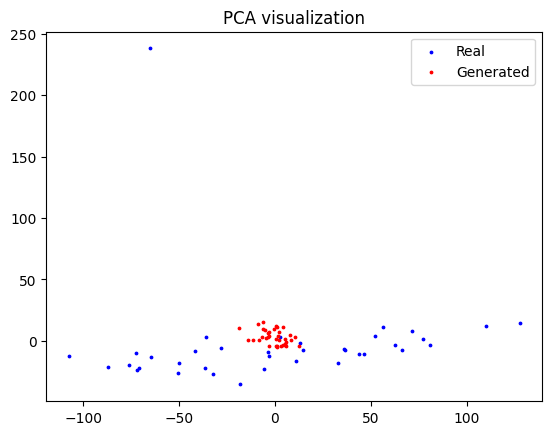

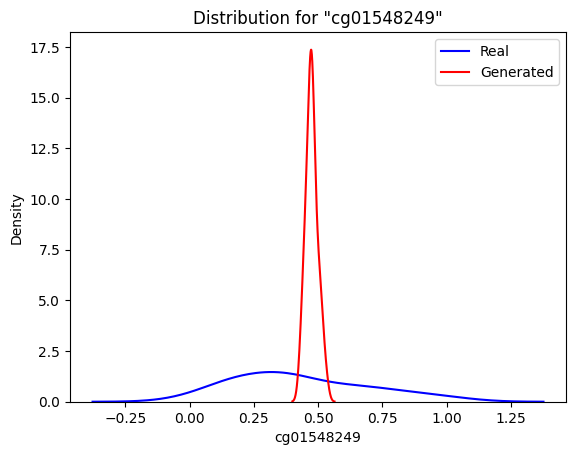

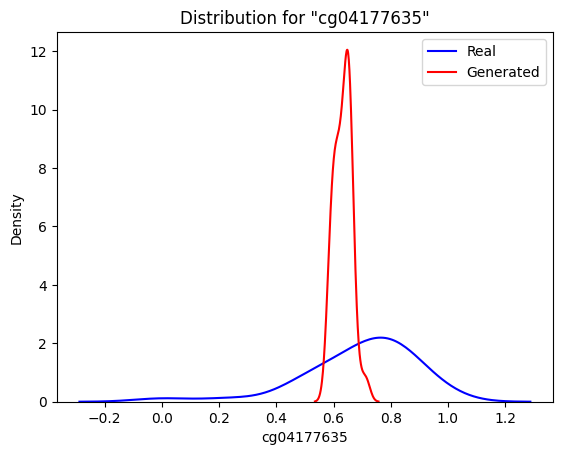

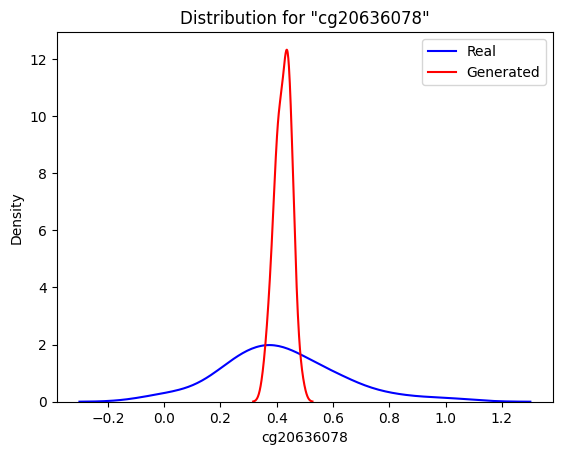

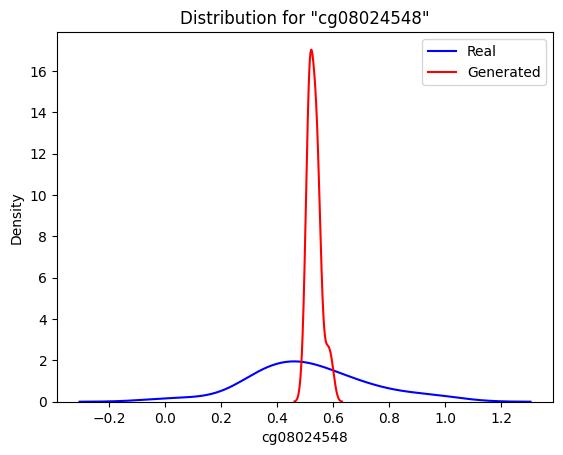

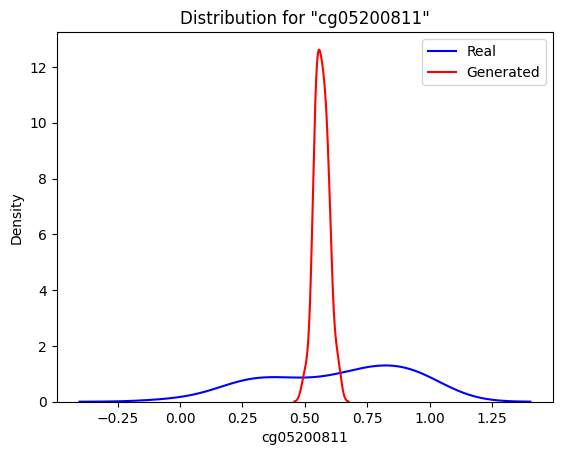

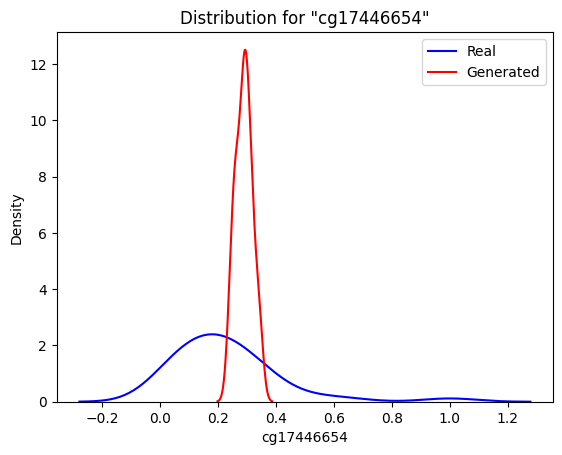

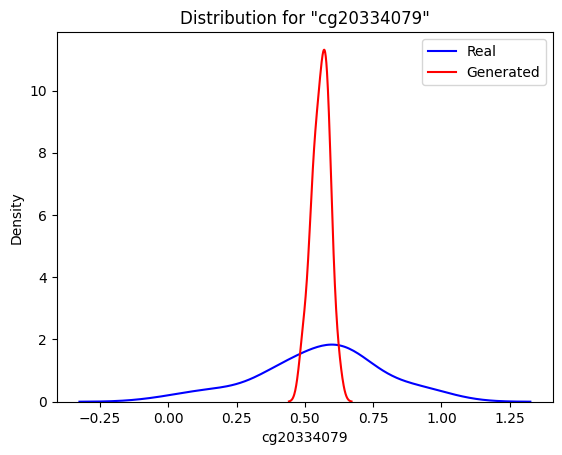

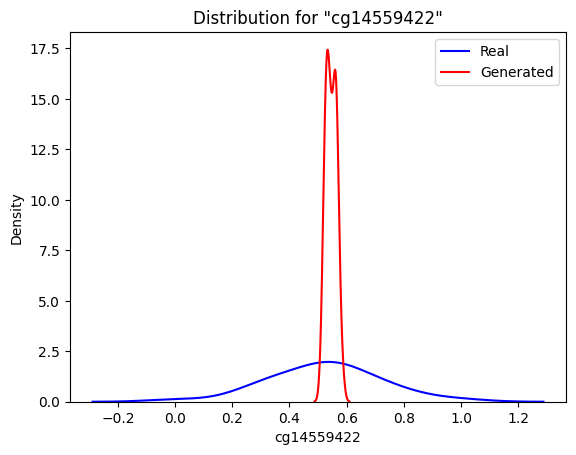

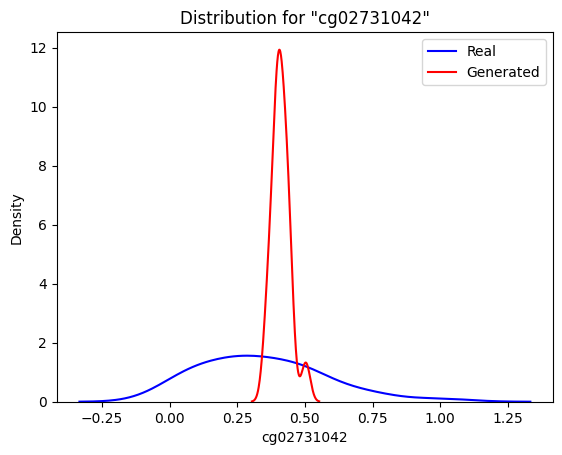

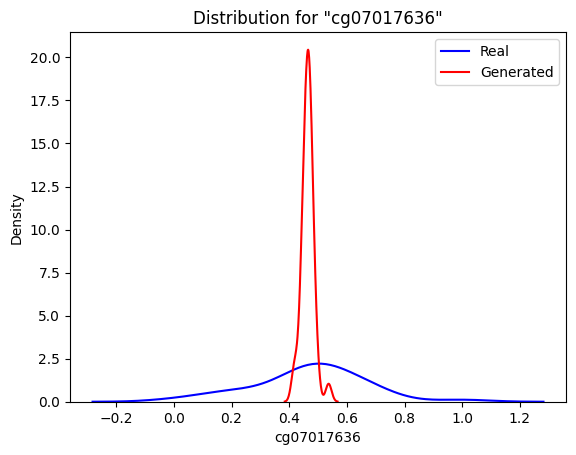

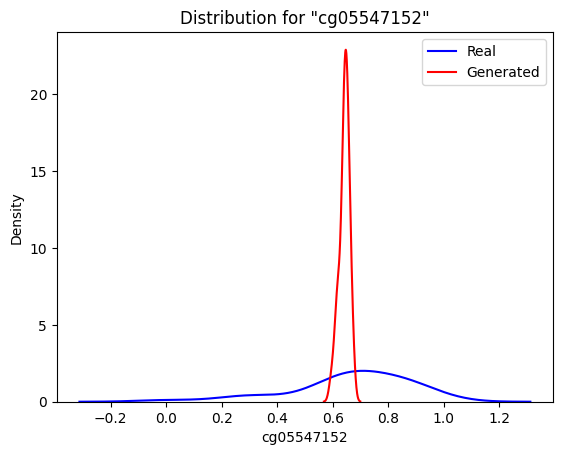

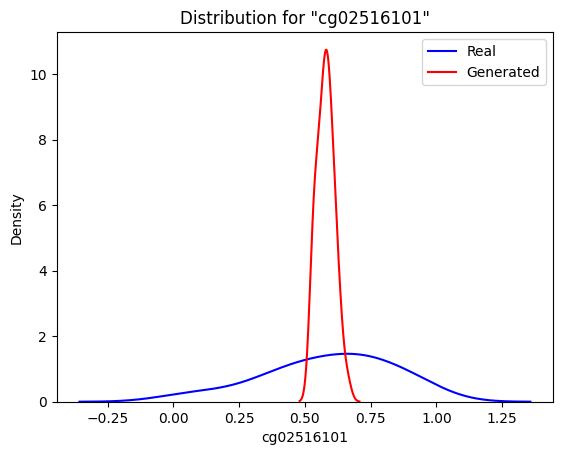

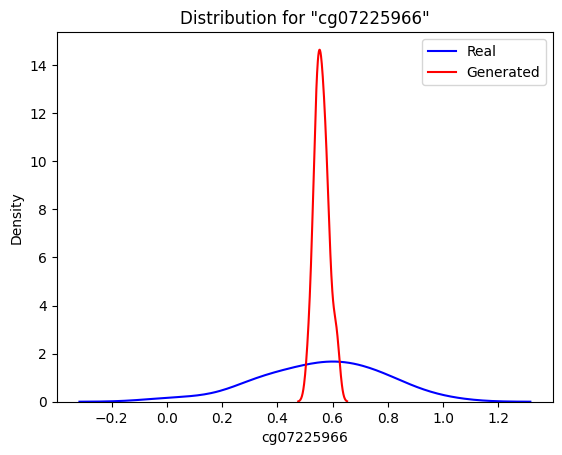

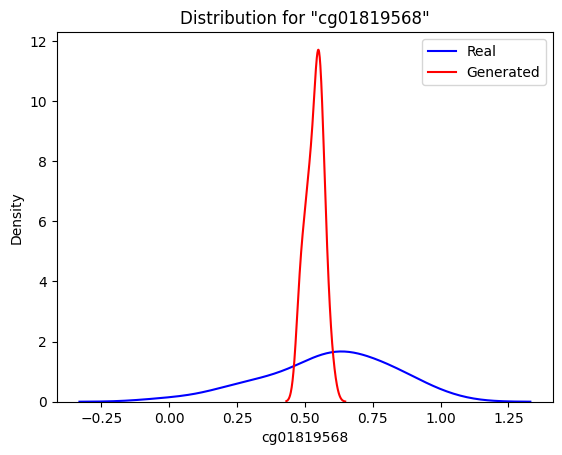

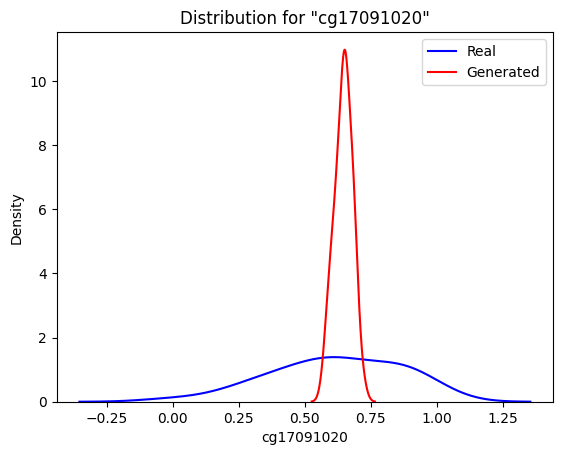

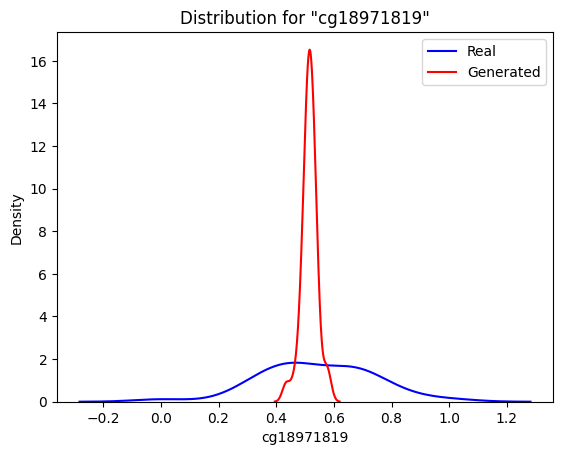

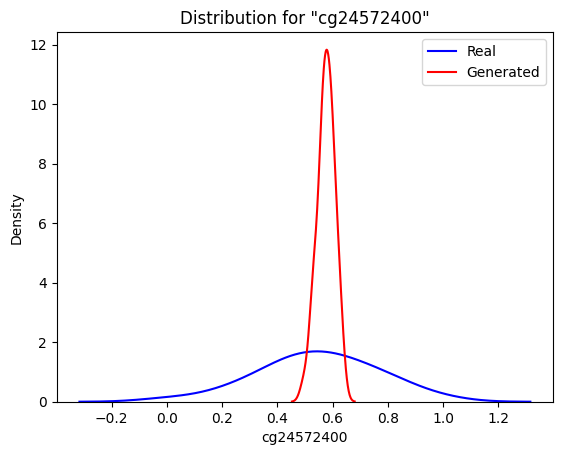

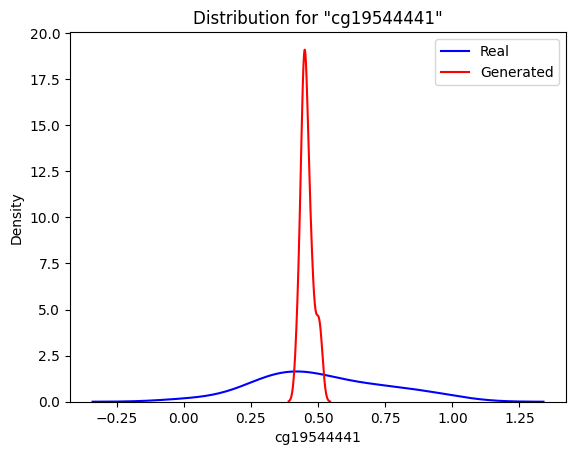

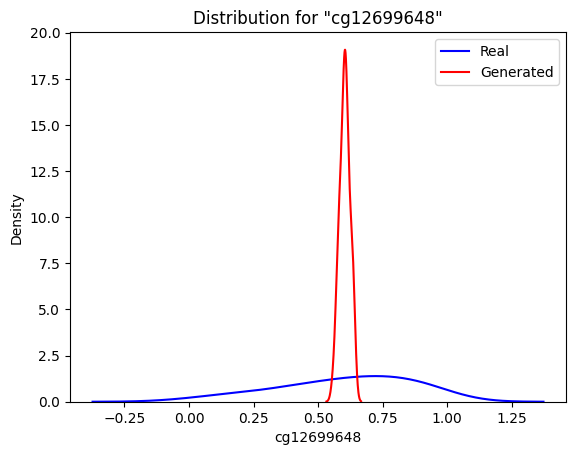

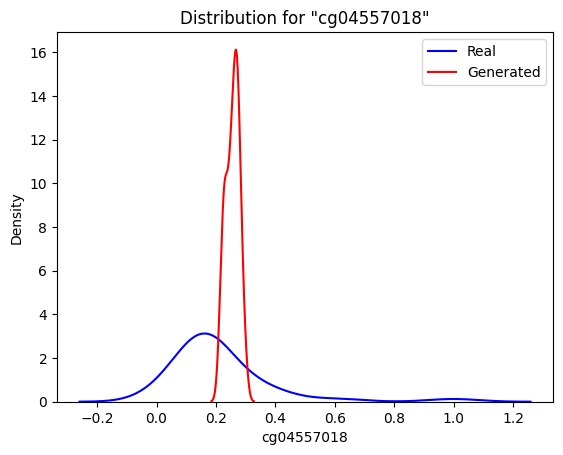

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import umap

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from scipy.stats import wasserstein_distance, ks_2samp
import sys
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sys.setrecursionlimit(20000)




# Eliminar estas columnas del DataFrame
expr_data = expression_data

meth_data = methylation_data
assig_data=assign_data
# Combinamos los datos de expresión génica y metilación
X_real = pd.concat([expr_data, meth_data], axis=1)


# Generar datos de expresión sintética
vae = VAE(expr_data.shape[1]+meth_data.shape[1]+assig_data.shape[1],ldim).to(device)
vae.load_state_dict(torch.load(f"{fnmodel}.pth"))
vae.eval()

# Función para reparametrización (para generar muestras del espacio latente)

# Generar datos de expresión sintética

with torch.no_grad():
    z = torch.randn(nsamp, ldim).to(device)
    synthetic_expression = vae.decoder(z).to(device)
    #synthetic_expression = torch.sigmoid(synthetic_expression)
    #print(synthetic_expression)
    expressions_list=synthetic_expression.detach().cpu().numpy().squeeze()

X_gan = pd.DataFrame(expressions_list)

y = X_gan.iloc[:, -1].values.astype(int)  # Suponiendo que la asignación está en la primera columna

X = X_gan.iloc[:, :-1]

last_column = X_gan.columns[-1]
X_gan = X_gan.drop(columns=[last_column])
X_gan.columns = X_real.columns
# Concatena los datos reales con los generados
X_combined = np.vstack([X_real, X_gan])


# Aplanar los datos para cálculos estadísticos
real_data_flattened = X_real.values.flatten()
generated_data_flattened = X_gan.values.flatten()

# Wasserstein Distance
w_distance = wasserstein_distance(real_data_flattened, generated_data_flattened)

# KS Test y Wassertein Distance
ks_statistic, ks_pvalue = ks_2samp(real_data_flattened, generated_data_flattened)

print(f"Wasserstein Distance: {w_distance}")
print(f"KS Statistic: {ks_statistic}, P-Value: {ks_pvalue}")


# Distancia Euclidiana
distancias_euclidianas = cdist(X_real, X_gan, metric='euclidean')
distancia_promedio_euclidiana = np.mean(distancias_euclidianas)
print("Distancia Euclidiana Promedio:", distancia_promedio_euclidiana)

# Calcula las matrices de correlación
#corr_real = X_real.corr()
#corr_gan = X_gan.corr()


# Dibuja las matrices de correlación
#plt.figure(figsize=(12, 6))

#plt.subplot(1, 2, 1)
#sns.heatmap(corr_real, cmap='coolwarm', vmin=-1, vmax=1)
#plt.title('Correlation Matrix (Real Data)')

#plt.subplot(1, 2, 2)
#sns.heatmap(corr_gan, cmap='coolwarm', vmin=-1, vmax=1)
#plt.title('Correlation Matrix (Generated Data)')

#plt.show()

# Calcula la matriz de diferencias
#corr_diff = corr_real - corr_gan

# Dibuja la matriz de diferencias
#plt.figure(figsize=(8, 6))
#sns.heatmap(corr_diff, cmap='coolwarm', vmin=-1, vmax=1)
#plt.title('Difference in Correlation Matrices')
#plt.show()

# Etiquetas: 1 para real, 0 para generado
y_real = [1] * X_real.shape[0]
y_gan = [0] * X_gan.shape[0]

# Combina los datos y las etiquetas
y_combined = y_real + y_gan

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.3, random_state=42)

# Inicializa y entrena el clasificador SVC
svc = SVC()
svc.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred = svc.predict(X_test)
# Evalúa el rendimiento del clasificador
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g',annot_kws={"size": 14})
plt.title('Clasificación de datos reales y generados juntos')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig(filename+"SVC1.jpg")
plt.show()


# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenamos el modelo SVC
clf = SVC()
unique_classes = np.unique(y_train)
if len(unique_classes) > 1:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g',annot_kws={"size": 14})
    plt.xlabel('Predicted')
    plt.title('Clasificación de datos generados')
    plt.ylabel('Truth')
    plt.savefig(filename+"SVC2.jpg")
    plt.show()
else:
    print("SVC: Solo una clase")

# Combinamos los datos de expresión génica y metilación
X2 = pd.concat([expr_data, meth_data], axis=1)
y2 = assig_data.iloc[:, 0].values  # Suponiendo que la asignación está en la primera columna

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

# Entrenamos el modelo SVC
clf = SVC()
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)

# Métricas de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g',annot_kws={"size": 14})
plt.xlabel('Predicted')
plt.title('Clasificación de datos reales')
plt.ylabel('Truth')
plt.show()


# Clustering jerárquico
linked1 = linkage(X_real, method='ward')
linked2 = linkage(X_gan, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked1, orientation='top', no_labels=True)
plt.title("Dendrograma jerárquico Real")
plt.savefig(filename+"DJR.jpg")
plt.show()

plt.figure(figsize=(10, 7))
dendrogram(linked2, orientation='top', no_labels=True)
plt.title("Dendrograma jerárquico Generado")
plt.savefig(filename+"DJG.jpg")
plt.show()


# K-Means
k = 2
kmeans = KMeans(n_clusters=k)
kmeans.fit(X_real)
labels = kmeans.predict(X_real)
centroids = kmeans.cluster_centers_
X_array = X_real.values
generated_data=X_gan.values
plt.scatter(X_array[:, 0], X_array[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(generated_data[:, 0], generated_data[:, 1], s=50, color='pink', label='Datos Generados')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.75)
plt.savefig(filename+"KNN.jpg")
plt.show()

# Aplicar t-SNE
# Crea etiquetas para los datos (1 para reales, 0 para GAN)
labels = np.concatenate([np.ones(X_real.shape[0]), np.zeros(X_gan.shape[0])])
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_combined)

plt.scatter(X_tsne[labels==1, 0], X_tsne[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_tsne[labels==0, 0], X_tsne[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('t-SNE visualization')
plt.savefig(filename+"tsne.jpg")
plt.show()

# Configurando y entrenando UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_combined)

# Dibujando la visualización
plt.scatter(X_umap[labels==1, 0], X_umap[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_umap[labels==0, 0], X_umap[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('UMAP visualization')
plt.savefig(filename+"umap.jpg")
plt.show()

#PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

plt.scatter(X_pca[labels==1, 0], X_pca[labels==1, 1], c='blue', label='Real', s=3)
plt.scatter(X_pca[labels==0, 0], X_pca[labels==0, 1], c='red', label='Generated', s=3)
plt.legend()
plt.title('PCA visualization')
plt.savefig(filename+"pca.jpg")
plt.show()

#KDE
column_names = X_real.columns.tolist()
random_columns = random.sample(column_names, 20)
for column_name in random_columns:
    sns.kdeplot(X_real[column_name], label='Real',color='blue')
    sns.kdeplot(X_gan[column_name], label='Generated',color='red')
    plt.legend()
    plt.title(f'Distribution for "{column_name}"')
    plt.savefig(f"{filename}kde-{column_name}.jpg")
    plt.show()